# Setup

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
!pip install git+https://github.com/samiriff/fastai-ssd.git

  Cloning https://github.com/samiriff/fastai-ssd.git to /tmp/pip-req-build-_7ydl_ak
  Running command git clone -q https://github.com/samiriff/fastai-ssd.git /tmp/pip-req-build-_7ydl_ak
  Stored in directory: /tmp/pip-ephem-wheel-cache-rlugdxrp/wheels/10/5d/17/cb2a8fd626c888b44acf2a715794690c758564a9ab22f0a9b6
Successfully built fastai-ssd


In [0]:
!wget -O images.zip https://files.slack.com/files-pri/TJRDXSH3L-FKMNSAEFK/download/images.zip?pub_secret=37264d575e

--2019-06-25 10:09:08--  https://files.slack.com/files-pri/TJRDXSH3L-FKMNSAEFK/download/images.zip?pub_secret=37264d575e
Resolving files.slack.com (files.slack.com)... 13.35.116.159
Connecting to files.slack.com (files.slack.com)|13.35.116.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19029399 (18M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]  18.15M  26.4MB/s    in 0.7s    

2019-06-25 10:09:09 (26.4 MB/s) - ‘images.zip’ saved [19029399/19029399]



In [0]:
!wget -O simple_ssd.pth https://files.slack.com/files-pri/TJRDXSH3L-FKP2R5B6V/download/simple_ssd.pth?pub_secret=f31dee20be

--2019-06-25 10:25:20--  https://files.slack.com/files-pri/TJRDXSH3L-FKP2R5B6V/download/simple_ssd.pth?pub_secret=f31dee20be
Resolving files.slack.com (files.slack.com)... 13.32.84.205
Connecting to files.slack.com (files.slack.com)|13.32.84.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92426730 (88M) [application/octet-stream]
Saving to: ‘simple_ssd.pth’

simple_ssd.pth      100%[===================>]  88.14M  33.5MB/s    in 2.6s    

2019-06-25 10:25:23 (33.5 MB/s) - ‘simple_ssd.pth’ saved [92426730/92426730]



In [0]:
!unzip -qq images.zip

In [0]:
from ssd_model.data_processor import SSDData
from ssd_model.model import SingleShotDetector
from pathlib import Path
import torch
from torch import nn

# Load Data

In [0]:
PATH = Path(r'images/')

In [0]:
data = SSDData(PATH).get_data_generator()

CPU times: user 3.82 s, sys: 1.89 s, total: 5.7 s
Wall time: 9.88 s


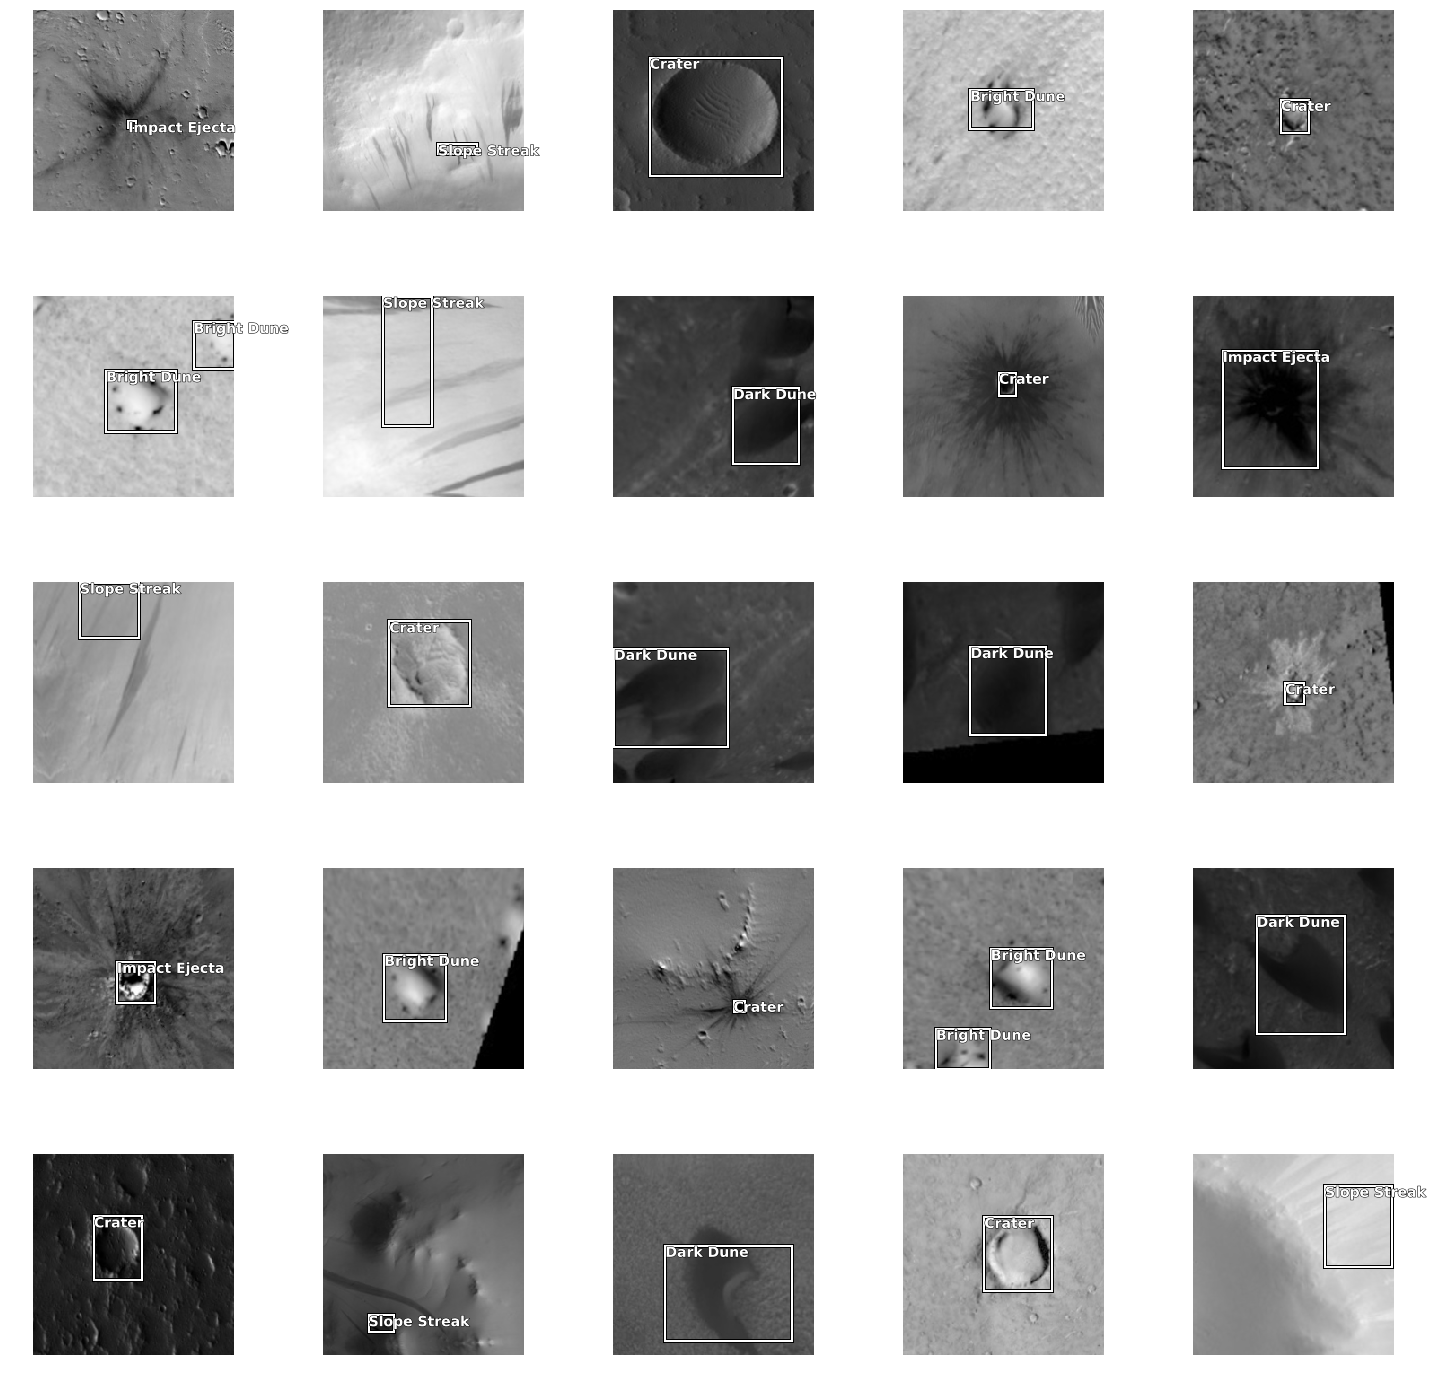

In [0]:
%%time
data.show_batch()

# Extract Feature Layers

## 1. Initialize Model

In [0]:
simple_ssd = SingleShotDetector(data, grids=[4], zooms=[1.0], ratios=[[1.0, 1.0]], focal_loss=True)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


## 2. Load Pre-Trained Model

In [0]:
simple_ssd.learn.model.load_state_dict(torch.load('simple_ssd.pth'))
simple_ssd.learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## 3. Identity Class to replace non-feature layers 

In [0]:
layer_0, layer_1 = list(simple_ssd.learn.model.children())

In [0]:
layer_1_drop = layer_1.drop
layer_1_sconvs = layer_1.sconvs
layer_1_oconvs = layer_1.oconvs

In [0]:
layer_1_oconvs[0].oconv1

Conv2d(256, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

## 4. Feature Outputs

### Feature Output 1

In [0]:
simple_ssd.learn.model._modules['1'] = nn.Sequential(layer_1_drop, layer_1_sconvs[0], layer_1_sconvs[1], layer_1_oconvs[0].oconv1)

In [0]:
simple_ssd.learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
sample_input_tensor = data.train_ds[0][0].px.unsqueeze(0).to(simple_ssd._device)
sample_input_tensor.shape

torch.Size([1, 3, 224, 224])

In [0]:
simple_ssd.learn.model(sample_input_tensor).shape

torch.Size([1, 6, 4, 4])

### Feature Output 2

In [0]:
simple_ssd.learn.model._modules['1'] = nn.Sequential(layer_1_drop, layer_1_sconvs[0], layer_1_sconvs[1], layer_1_oconvs[0].oconv2)

In [0]:
simple_ssd.learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
sample_input_tensor = data.train_ds[0][0].px.unsqueeze(0).to(simple_ssd._device)
sample_input_tensor.shape

torch.Size([1, 3, 224, 224])

In [0]:
simple_ssd.learn.model(sample_input_tensor)[0].shape

torch.Size([4, 4, 4])